# Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.utils.data as data
import torch.optim as optim
from torchvision import transforms

from sklearn import metrics

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import copy
import time
import random
from tqdm.auto import tqdm
from PIL import Image
from glob import glob

# Set the random seed for Python, Numpy and PyTorch

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Upload dataset from Kaggle to Google Colab

## Upload API Token to Google Colaboratory (Upload API Token lên Google Colaboratory)

In [ ]:
# Use lines if you want to upload `kaggle.json` file from your computer
#from google.colab import files
#files.upload()

# Use lines if you want to upload `kaggle.json` file from Google Drive
from google.colab import drive
drive.mount('/content/drive')

from IPython import display
display.clear_output()

## Setting and configuring Kaggle API (Cài đặt và cấu hình Kaggle API)

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
# Use this line if you upload `kaggle.json` file from your computer
#!cp kaggle.json ~/.kaggle/

# Use this line if you upload `kaggle.json` file from Google Drive
!cp /content/drive/MyDrive/Colab Notebooks/Mini Project Computer Vision/Traffic Signs/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

from IPython import display
display.clear_output()

## Download dataset from Kaggle (Tải dataset từ Kaggle)

In [ ]:
user_name = "tuanai"
dataset_name = "traffic-signs-dataset"

In [ ]:
!kaggle datasets download -d {user_name}/{dataset_name}

Dataset URL: https://www.kaggle.com/datasets/tuanai/traffic-signs-dataset
License(s): apache-2.0
 97% 225M/232M [00:02<00:00, 92.9MB/s]
100% 232M/232M [00:02<00:00, 90.5MB/s]


## Unzip the dataset

In [ ]:
!unzip {dataset_name}.zip -d /content/{dataset_name}

from IPython import display
display.clear_output()

# Create Mean and Standard

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data Augmentation

In [ ]:
image_size = 112

train_transforms = transforms.Compose([
                            transforms.Resize((image_size, image_size)),
                            transforms.RandomAffine(degrees=20, shear=10),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                                      ])

test_transforms = transforms.Compose([
                           transforms.Resize((image_size, image_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=mean, std=std)
                                     ])

# Custom Dataset

In [ ]:
class TrafficSignsDataset(data.Dataset):
    def __init__(self, dataset_name, data, transform=None, image_files = [".jpg", ".jpeg", ".png"]):
        self.transform = transform

        # Read CSV File and get each column from that file
        labels = pd.read_csv(f'/content/{dataset_name}/labels.csv')
        self.class_id = list(labels["ClassId"])
        self.class_name = list(labels["Name"])

        # Get all image files from each folder and sort them with acsending
        # Acsending with folder first if we get the dir path
        self.image_path = sorted(glob(f"/content/{dataset_name}/{data}/*/*{[image_file for image_file in image_files]}"))

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]
        image = Image.open(image_path).convert('RGB')
        '''
        Example :
        image_path = '/content/traffic-signs-dataset/DATA/0/00001.jpg'
        os.path.dirname ---> '/content/traffic-signs-dataset/DATA/0'
        os.path.basename ---> '0' ; int('0') ---> class_id : 0
        ---> label = self.class_name[self.class_id.index(class_id)] ---> label = 'Speed limit (20km/h)'
        '''
        class_id = int(os.path.basename(os.path.dirname(image_path)))
        label = self.class_name[self.class_id.index(class_id)]

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(class_id)

        return image, label

In [ ]:
train_images = TrafficSignsDataset(dataset_name = dataset_name, data = 'DATA', transform=train_transforms)
test_images = TrafficSignsDataset(dataset_name = dataset_name, data = 'TEST', transform=test_transforms)

# Data Visualization

In [ ]:
def plot_images(dataset, num_images, original_dataset=None):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        image, label = random.choice(dataset)

        # Convert tensor to numpy array (Chuyển đổi tensor sang mảng numpy) ((C, H, W) ---> (H, W, C))
        image_np = np.array(image.permute(1, 2, 0))
        image_np = (image_np * np.array(std) + np.array(mean)) * 255
        image_np = image_np.astype(np.uint8)

        # Determine where to get the class_name (Xác định nơi để lấy class_name)
        if original_dataset:
            label_str = original_dataset.class_name[int(label.item())]
        else:
            label_str = dataset.class_name[int(label.item())]

        plt.subplot(5, 5, i+1)
        plt.imshow(image_np)
        plt.title(f'Label : {label_str}')
        plt.axis('off')
    plt.show()

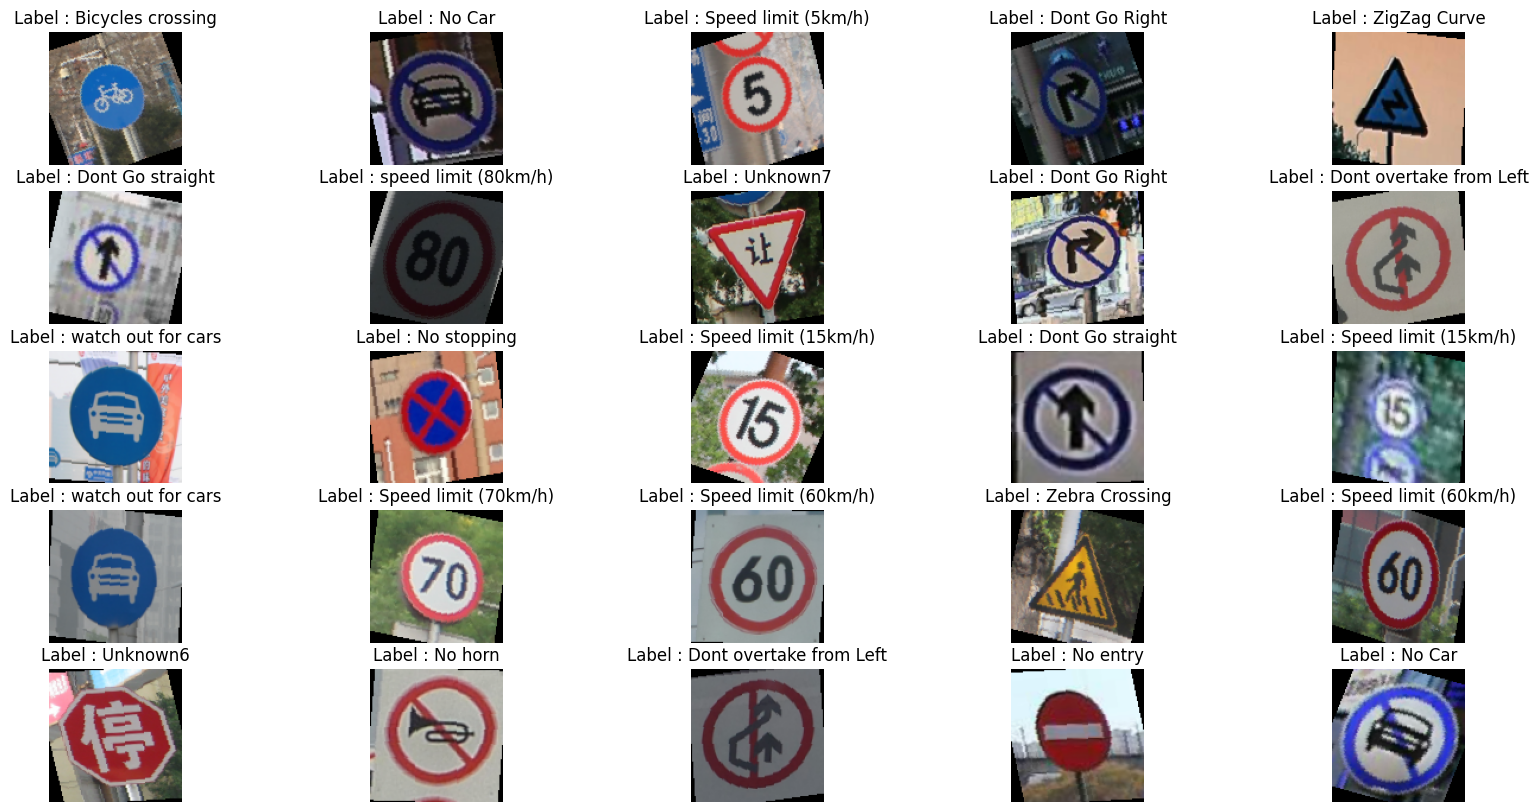

In [ ]:
plot_images(train_images, num_images = 25)

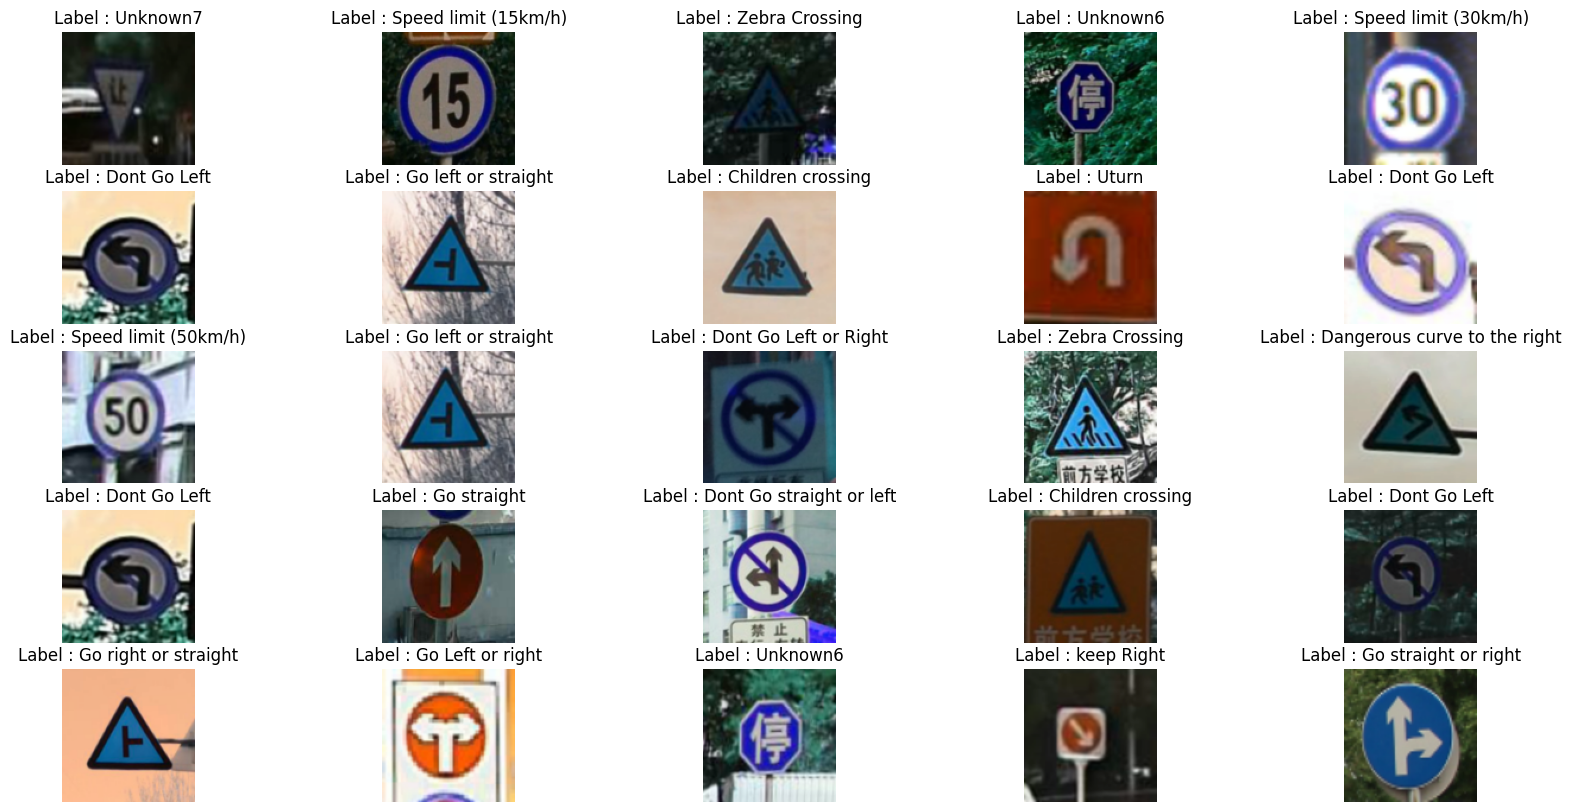

In [ ]:
plot_images(test_images, num_images = 25)

In [ ]:
VALID_RATIO = 0.1
valid_size = int(len(train_images) * VALID_RATIO)
train_size = len(train_images) - valid_size

print(f'Train images : {train_size}')
print(f'Valid images : {valid_size}')

Train images : 5115
Valid images : 568


In [ ]:
# Split current train dataset into train and valid dataset
# Chia tập train hiện tại thành tập train và tập valid
train_set, valid_set = data.random_split(train_images, [train_size, valid_size])

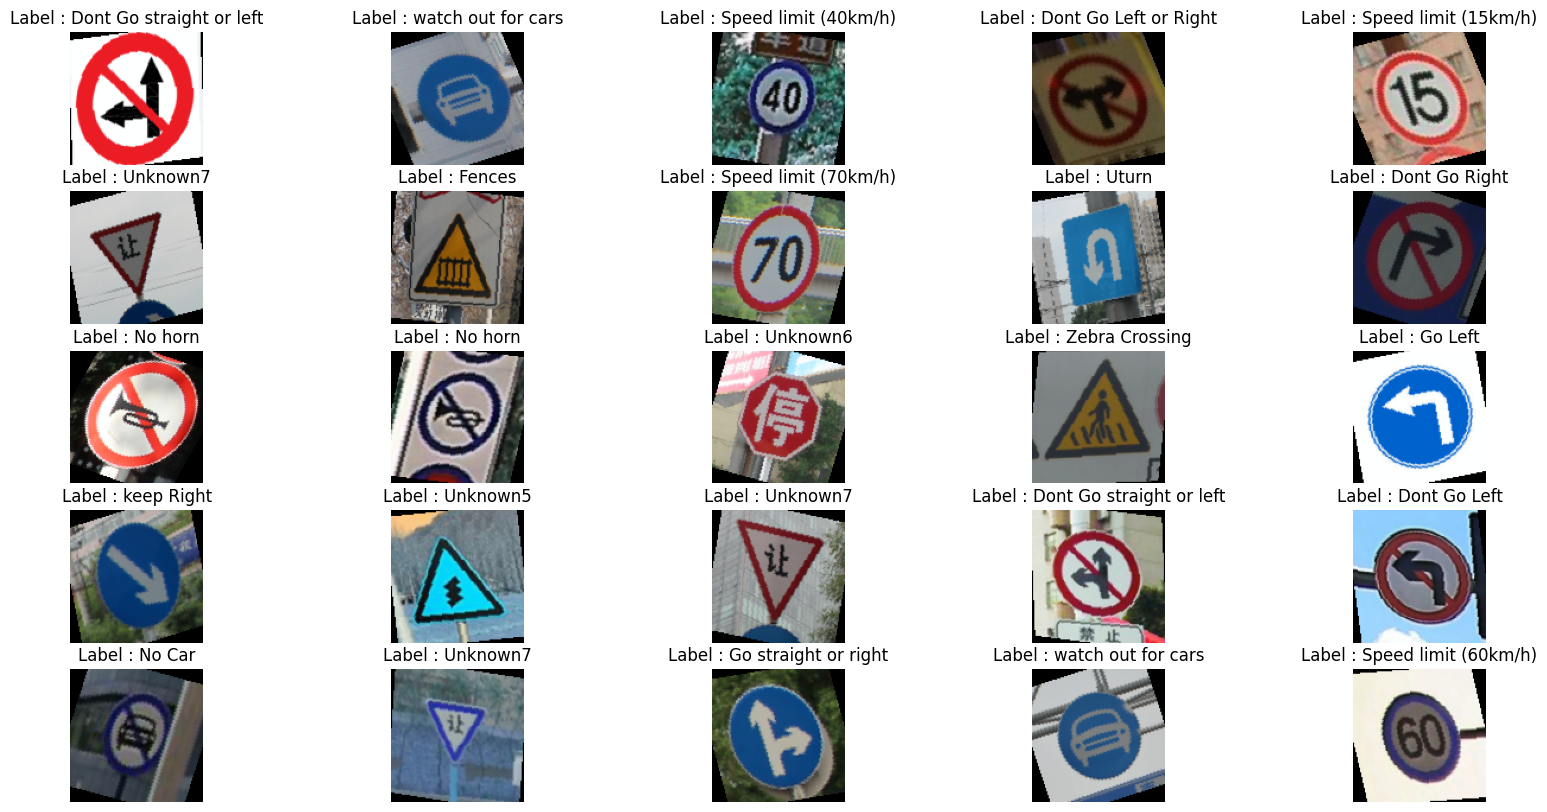

In [ ]:
plot_images(train_set, num_images=25, original_dataset=train_images)

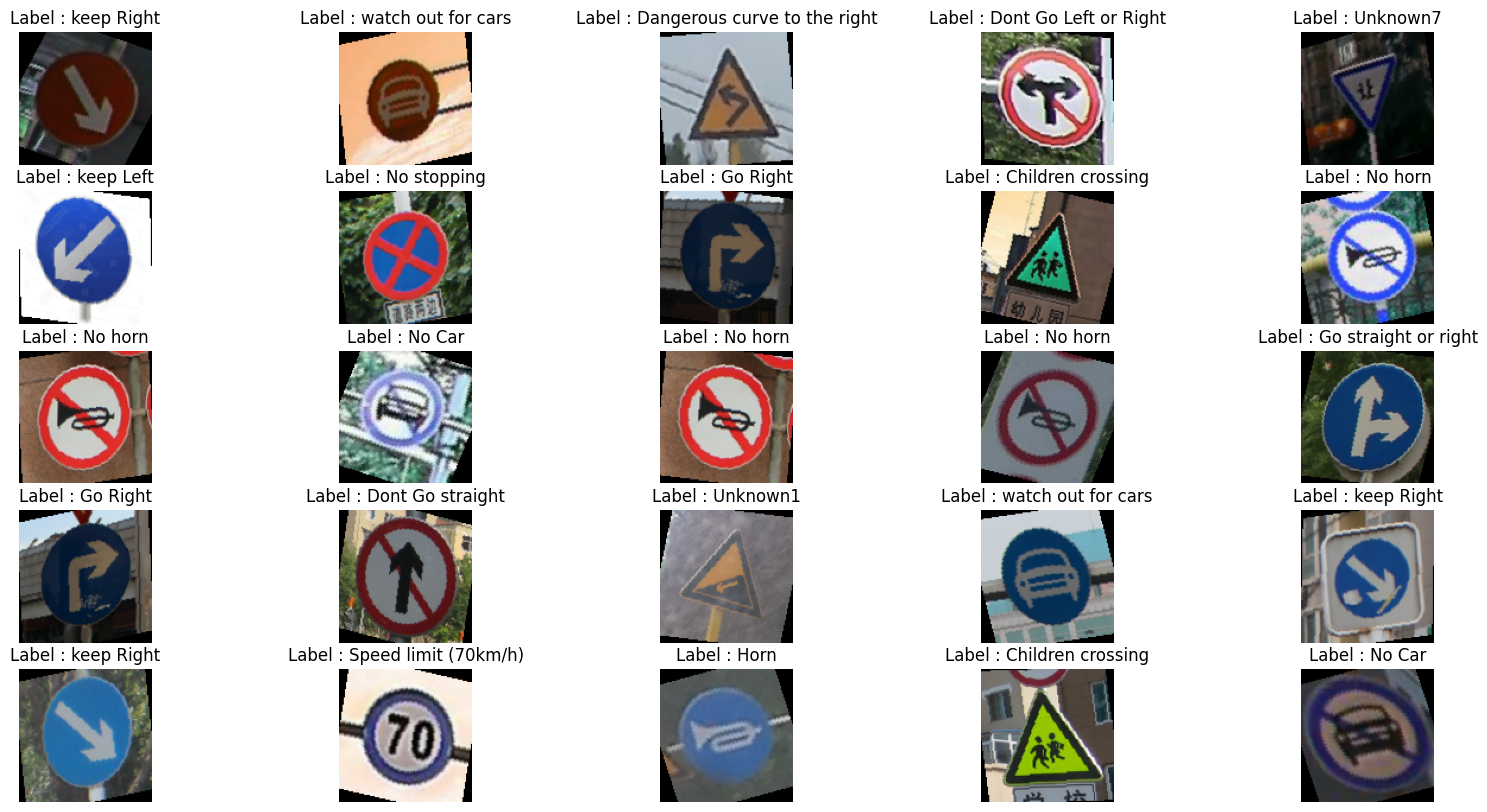

In [ ]:
plot_images(valid_set, num_images = 25, original_dataset=train_images)

In [ ]:
valid_set = copy.deepcopy(valid_set)
valid_set.dataset.transform = test_transforms

# Set the Batch Size and get types of dataset to DataLoader

In [ ]:
BATCH_SIZE = 64

# Create DataLoaders (Tạo các DataLoader)
train_loader = data.DataLoader(train_set,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

valid_loader = data.DataLoader(valid_set,
                               batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_images,
                              batch_size=BATCH_SIZE)

# Using VGG-11 model to classify

In [ ]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:04<00:00, 122MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

## Take the last row in classifier of model

In [ ]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

## Adjust out_features to fit the label of dataset

In [ ]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

OUTPUT_DIM = 52

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

## Overwrite the last row in classifier of model

In [ ]:
pretrained_model.classifier[-1] = final_fc

In [ ]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=52, bias=True)
)


In [ ]:
model = pretrained_model

## Load the 'knowledge' into the model

In [ ]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

## Count parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,984,884 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 1.330 | Train Acc: 65.24%
	 Val. Loss: 0.561 |  Val. Acc: 83.61%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.503 | Train Acc: 87.72%
	 Val. Loss: 5.231 |  Val. Acc: 61.88%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.934 | Train Acc: 85.77%
	 Val. Loss: 3.797 |  Val. Acc: 82.07%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.352 | Train Acc: 92.83%
	 Val. Loss: 0.203 |  Val. Acc: 95.44%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.253 | Train Acc: 94.14%
	 Val. Loss: 0.122 |  Val. Acc: 95.44%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.431 | Train Acc: 92.51%
	 Val. Loss: 0.237 |  Val. Acc: 95.78%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 35s
	Train Loss: 0.174 | Train Acc: 96.09%
	 Val. Loss: 0.105 |  Val. Acc: 97.54%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.170 | Train Acc: 96.81%
	 Val. Loss: 0.195 |  Val. Acc: 97.02%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.101 | Train Acc: 97.64%
	 Val. Loss: 0.187 |  Val. Acc: 95.66%


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 35s
	Train Loss: 0.135 | Train Acc: 97.09%
	 Val. Loss: 0.061 |  Val. Acc: 98.07%


In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.152 | Test Acc: 96.96%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_loader, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(52))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

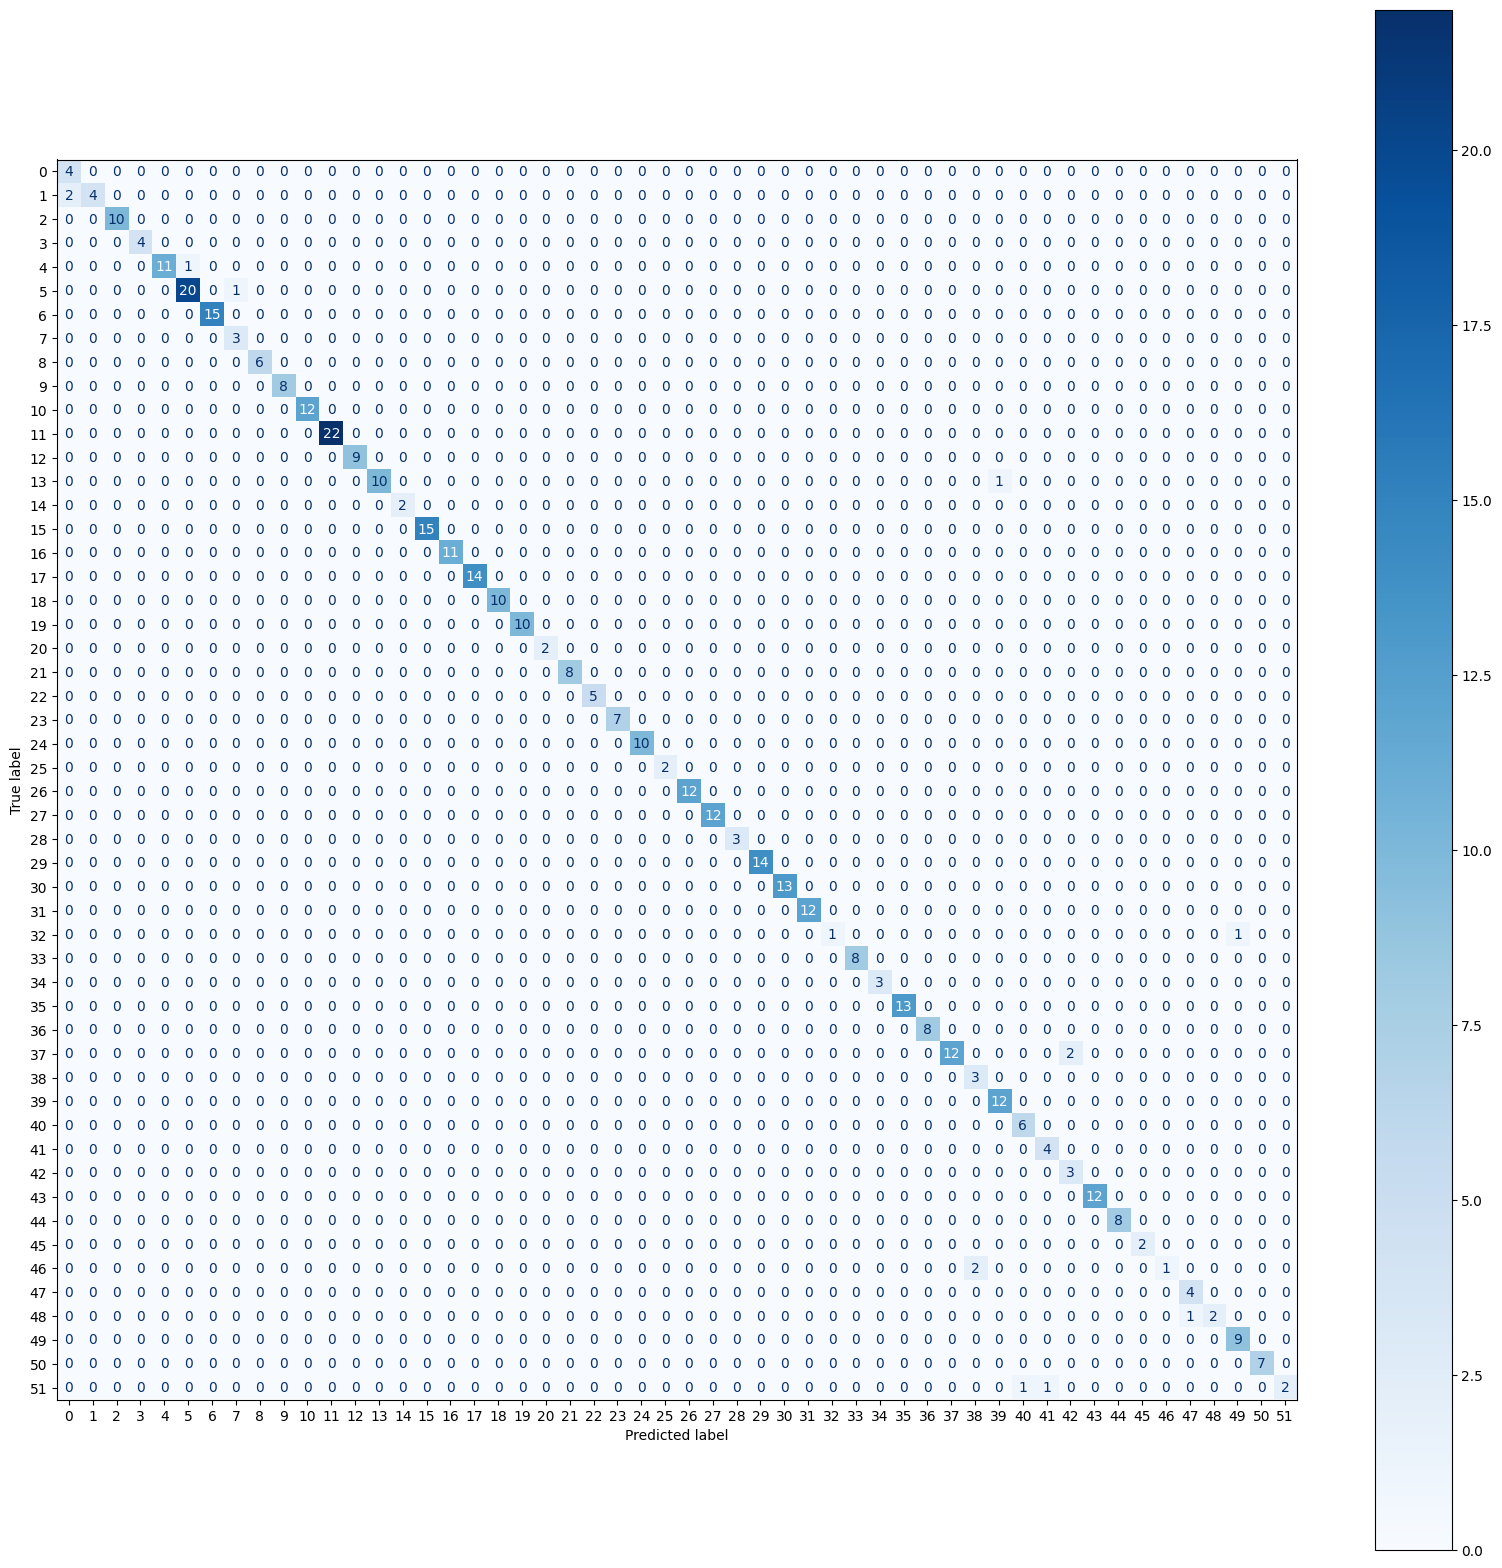

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    # Reread CSV File (Đọc lại tệp CSV)

    labels = pd.read_csv(f'/content/{dataset_name}/labels.csv')

    fig = plt.figure(figsize=(25,10))
    for i in range(rows*cols):

        # Handle the case where there are no more incorrect examples (Xử lý trường hợp không có ví dụ nào sai nữa)
        if i >= len(incorrect_examples):
            break

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]

        # Adjust image (Điều chỉnh hình ảnh)
        image = np.array(image.permute(1, 2, 0))
        image = (image * np.array(std) + np.array(mean)) * 255
        image = image.astype(np.uint8)

        true_label = int(true_label.item())
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)

        # Chuyển nhãn số thành nhãn chữ (Convert number labels to text labels)
        true_label_text = labels.loc[true_label, 'Name']
        incorrect_label_text = labels.loc[incorrect_label.item(), 'Name']

        ax.imshow(image.reshape(112, 112, 3))
        ax.set_title(f'true label: {true_label_text} ({true_label}) ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label_text} ({incorrect_label}) ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

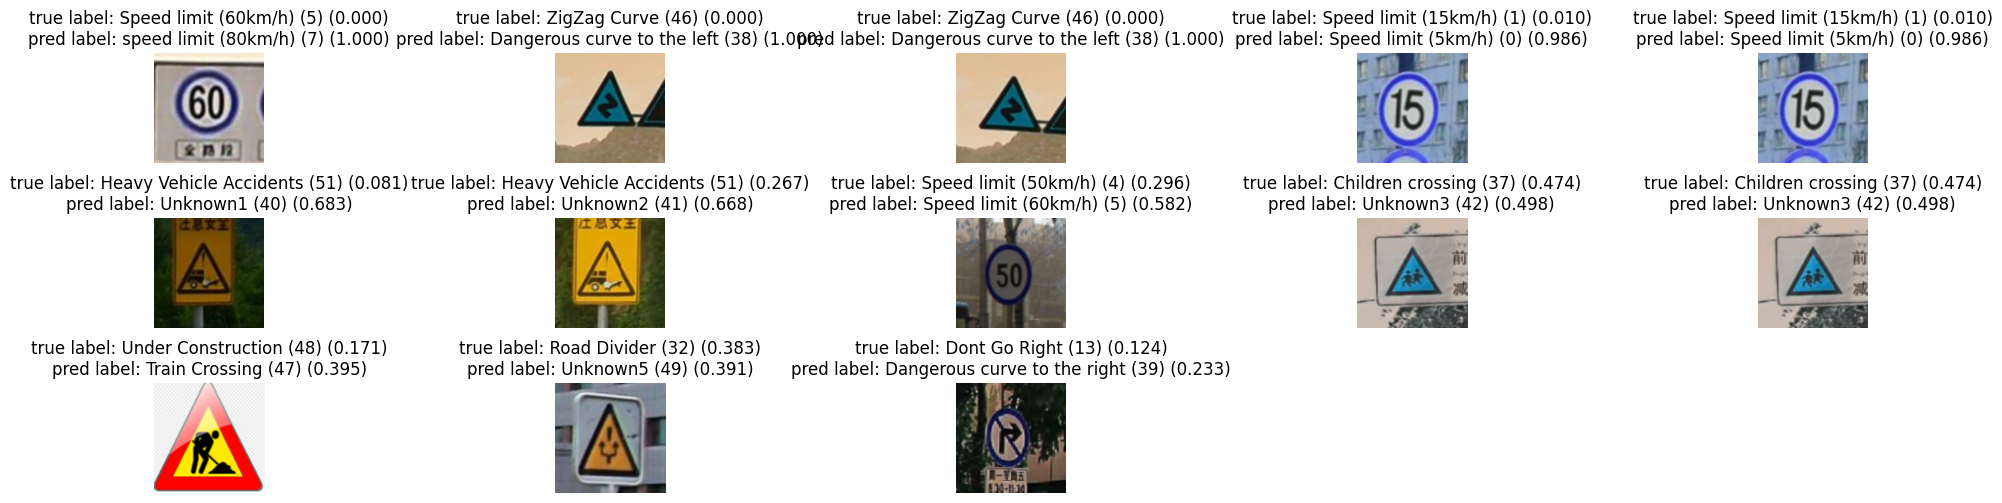

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)